In [37]:
import nltk
nltk.download('stopwords')
from sklearn.metrics import classification_report

import os
import re
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import itertools

import pandas as pd

import seaborn as sns
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from wordcloud import WordCloud, STOPWORDS



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train=pd.read_csv('/content/drive/MyDrive/Fake_news/train.csv')
test=pd.read_csv('/content/drive/MyDrive/Fake_news/test.csv')

In [4]:
print(train.shape, test.shape)

(20800, 5) (5200, 4)


In [5]:
train.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [6]:
print(train.isnull().sum())
print('************')
print(test.isnull().sum())

id           0
title      558
author    1957
text        39
label        0
dtype: int64
************
id          0
title     122
author    503
text        7
dtype: int64


In [7]:
train = train.dropna()

print(train.shape)

(18285, 5)


In [8]:
test = test.dropna()

print(test.shape)

(4575, 4)


In [9]:
train['total'] = train['title'] + ' ' + train['author'] + ' ' + train['text']
test['total']  = test['title']  + ' ' + test['author']  + ' ' + test['text']

In [10]:
X = train.drop('label', axis=1)
print(X.shape)

(18285, 5)


In [11]:
y = train['label']
print(y.shape)

(18285,)


# Creating Wordcloud Visuals

In [12]:
real_words = ''
fake_words = ''
stopwords = set(stopwords.words('english'))


train['total'] = train['total'].astype(str)
train['total'] = train['total'].str.lower()

real_words = train.loc[train['label'] == 1, 'total'].str.cat(sep=' ')
fake_words = train.loc[train['label'] == 0, 'total'].str.cat(sep=' ')

In [13]:
print(real_words[:10000].split(' '))

['house', 'dem', 'aide:', 'we', 'didn’t', 'even', 'see', 'comey’s', 'letter', 'until', 'jason', 'chaffetz', 'tweeted', 'it', 'darrell', 'lucus', 'house', 'dem', 'aide:', 'we', 'didn’t', 'even', 'see', 'comey’s', 'letter', 'until', 'jason', 'chaffetz', 'tweeted', 'it', 'by', 'darrell', 'lucus', 'on', 'october', '30,', '2016', 'subscribe', 'jason', 'chaffetz', 'on', 'the', 'stump', 'in', 'american', 'fork,', 'utah', '(', 'image', 'courtesy', 'michael', 'jolley,', 'available', 'under', 'a', 'creative', 'commons-by', 'license)', '\nwith', 'apologies', 'to', 'keith', 'olbermann,', 'there', 'is', 'no', 'doubt', 'who', 'the', 'worst', 'person', 'in', 'the', 'world', 'is', 'this', 'week–fbi', 'director', 'james', 'comey.', 'but', 'according', 'to', 'a', 'house', 'democratic', 'aide,', 'it', 'looks', 'like', 'we', 'also', 'know', 'who', 'the', 'second-worst', 'person', 'is', 'as', 'well.', 'it', 'turns', 'out', 'that', 'when', 'comey', 'sent', 'his', 'now-infamous', 'letter', 'announcing', 'tha

In [14]:
print(fake_words[:10000].split(' '))

['flynn:', 'hillary', 'clinton,', 'big', 'woman', 'on', 'campus', '-', 'breitbart', 'daniel', 'j.', 'flynn', 'ever', 'get', 'the', 'feeling', 'your', 'life', 'circles', 'the', 'roundabout', 'rather', 'than', 'heads', 'in', 'a', 'straight', 'line', 'toward', 'the', 'intended', 'destination?', '[hillary', 'clinton', 'remains', 'the', 'big', 'woman', 'on', 'campus', 'in', 'leafy,', 'liberal', 'wellesley,', 'massachusetts.', 'everywhere', 'else', 'votes', 'her', 'most', 'likely', 'to', 'don', 'her', 'inauguration', 'dress', 'for', 'the', 'remainder', 'of', 'her', 'days', 'the', 'way', 'miss', 'havisham', 'forever', 'wore', 'that', 'wedding', 'dress.', '', 'speaking', 'of', 'great', 'expectations,', 'hillary', 'rodham', 'overflowed', 'with', 'them', '48', 'years', 'ago', 'when', 'she', 'first', 'addressed', 'a', 'wellesley', 'graduating', 'class.', 'the', 'president', 'of', 'the', 'college', 'informed', 'those', 'gathered', 'in', '1969', 'that', 'the', 'students', 'needed', '“no', 'debate',

### Words in real news

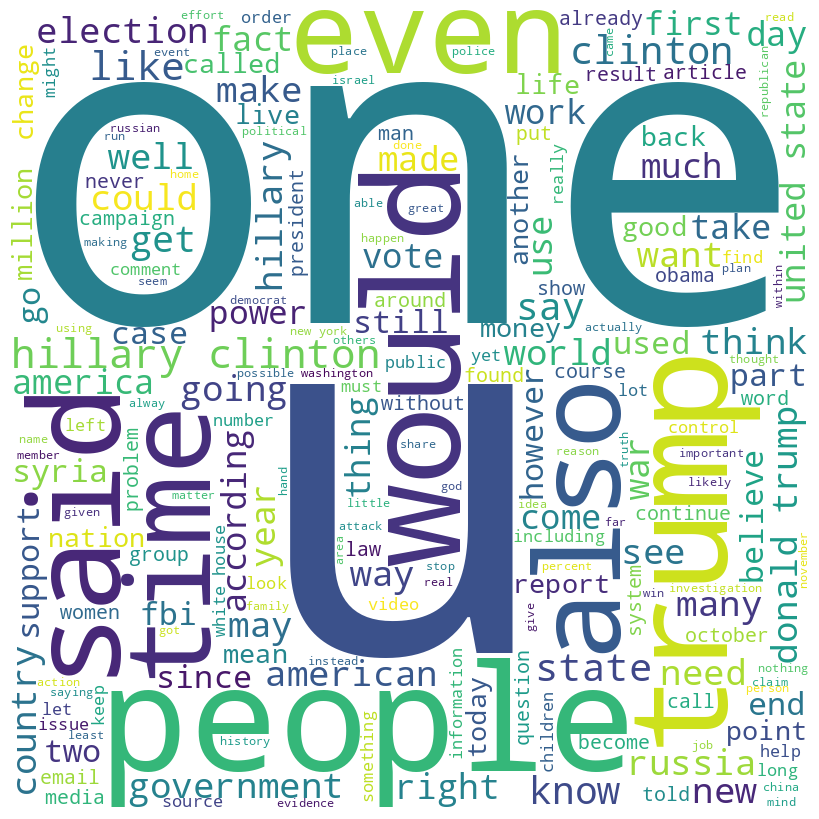

In [15]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(real_words)

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

### Words in Fake news

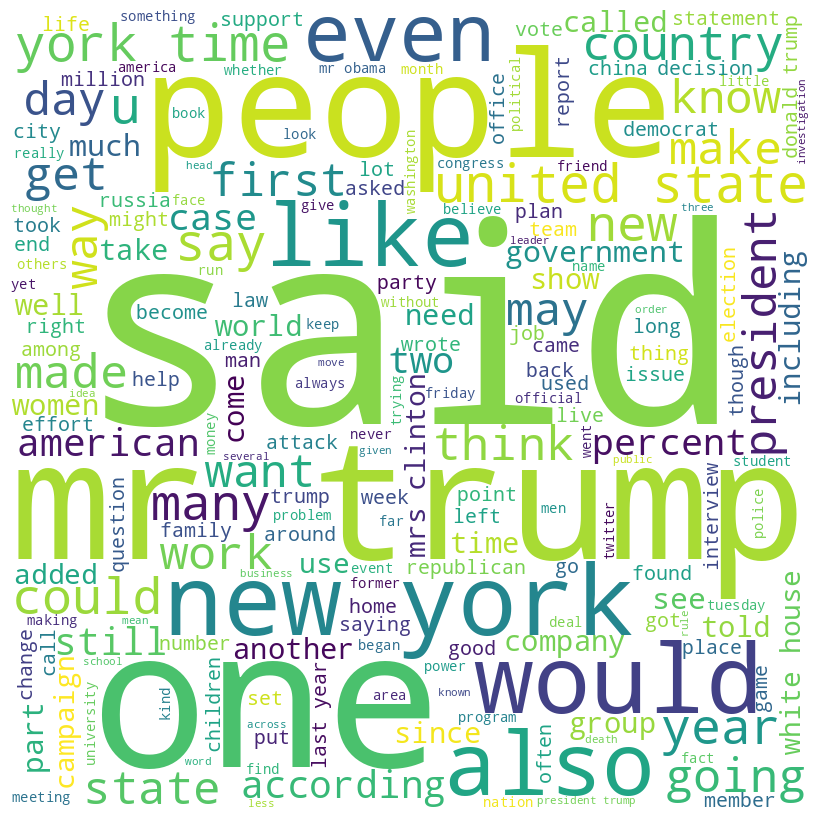

In [16]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(fake_words)

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

In [17]:
msg=X.copy()

In [18]:
msg.reset_index(inplace=True)

In [19]:
msg

,index,id,title,author,text,total
0,0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,House Dem Aide: We Didn’t Even See Comey’s Let...
1,1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,"FLYNN: Hillary Clinton, Big Woman on Campus - ..."
2,2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",Why the Truth Might Get You Fired Consortiumne...
3,3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,15 Civilians Killed In Single US Airstrike Hav...
4,4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,Iranian woman jailed for fictional unpublished...
...,...,...,...,...,...,...
18280,20795,20795,Rapper T.I.: Trump a ’Poster Child For White S...,Jerome Hudson,Rapper T. I. unloaded on black celebrities who...,Rapper T.I.: Trump a ’Poster Child For White S...
18281,20796,20796,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",Benjamin Hoffman,When the Green Bay Packers lost to the Washing...,"N.F.L. Playoffs: Schedule, Matchups and Odds -..."
18282,20797,20797,Macy’s Is Said to Receive Takeover Approach by...,Michael J. de la Merced and Rachel Abrams,The Macy’s of today grew from the union of sev...,Macy’s Is Said to Receive Takeover Approach by...
18283,20798,20798,"NATO, Russia To Hold Parallel Exercises In Bal...",Alex Ansary,"NATO, Russia To Hold Parallel Exercises In Bal...","NATO, Russia To Hold Parallel Exercises In Bal..."


# Cleaning and preprocessing

In [20]:
nltk.download('wordnet')
lemmatizer=WordNetLemmatizer()
corpus=[]
for i in range(0,len(msg)):
    review=re.sub('[^a-zA-Z]', ' ', msg['text'][i])
    review = review.lower()
    review = review.split()

    review = [lemmatizer.lemmatize(word) for word in review if not word in stopwords]
    review=' '.join(review)
    corpus.append(review)



[nltk_data] Downloading package wordnet to /root/nltk_data...


In [21]:
max_sent = 0
for i in range(len(msg['text'])):
    leng = len(msg['text'][i])
    if leng > max_sent:
        max_sent=leng

In [22]:
max_sent

142961

In [23]:
voc=10000
onehot_repr=[one_hot(words,voc)for words in corpus]

In [24]:
embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=max_sent)
print(embedded_docs)

[[   0    0    0 ... 9827 5897 7351]
 [   0    0    0 ... 8009  584 7545]
 [   0    0    0 ... 1268 7169   98]
 ...
 [   0    0    0 ... 7924 4371 3173]
 [   0    0    0 ... 3179 8162 9344]
 [   0    0    0 ... 6309 6919 7793]]


In [25]:
X_final=np.array(embedded_docs)
y_final=np.array(y)

X_final.shape,y_final.shape

((18285, 142961), (18285,))

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.33, random_state=42)

In [27]:
y_train

array([1, 1, 0, ..., 0, 0, 1])

In [28]:
embedding_vector_features=40

rnn = Sequential()
rnn.add(Input(shape=(max_sent,)))
rnn.add(Embedding(input_dim=voc, output_dim=embedding_vector_features))
rnn.add(SimpleRNN(100, return_sequences=False))
rnn.add(Dense(1, activation='sigmoid'))

rnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 142961, 40)     │       400,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 100)            │        14,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 414,201 (1.58 MB)

 Trainable params: 414,201 (1.58 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
rnn.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
history = rnn.fit(X_train, y_train,epochs=8,batch_size=32,validation_data=(X_test,y_test))

Epoch 1/8
383/383 ━━━━━━━━━━━━━━━━━━━━ 4382s 11s/step - accuracy: 0.6072 - loss: 0.6595 - val_accuracy: 0.7256 - val_loss: 0.5859
Epoch 2/8
383/383 ━━━━━━━━━━━━━━━━━━━━ 4394s 11s/step - accuracy: 0.7939 - loss: 0.5183 - val_accuracy: 0.8862 - val_loss: 0.3475
Epoch 3/8
383/383 ━━━━━━━━━━━━━━━━━━━━ 4395s 11s/step - accuracy: 0.9112 - loss: 0.2796 - val_accuracy: 0.9213 - val_loss: 0.2386
Epoch 4/8
383/383 ━━━━━━━━━━━━━━━━━━━━ 4395s 11s/step - accuracy: 0.9414 - loss: 0.1823 - val_accuracy: 0.9238 - val_loss: 0.2164
Epoch 5/8
383/383 ━━━━━━━━━━━━━━━━━━━━ 4400s 11s/step - accuracy: 0.9625 - loss: 0.1255 - val_accuracy: 0.9135 - val_loss: 0.2261
Epoch 6/8
383/383 ━━━━━━━━━━━━━━━━━━━━ 4395s 11s/step - accuracy: 0.9699 - loss: 0.1015 - val_accuracy: 0.9317 - val_loss: 0.2014
Epoch 7/8
383/383 ━━━━━━━━━━━━━━━━━━━━ 4394s 11s/step - accuracy: 0.8657 - loss: 0.2702 - val_accuracy: 0.7307 - val_loss: 0.5397
Epoch 8/8
383/383 ━━━━━━━━━━━━━━━━━━━━ 4395s 11s/step - accuracy: 0.8250 - loss: 0.4558 - 

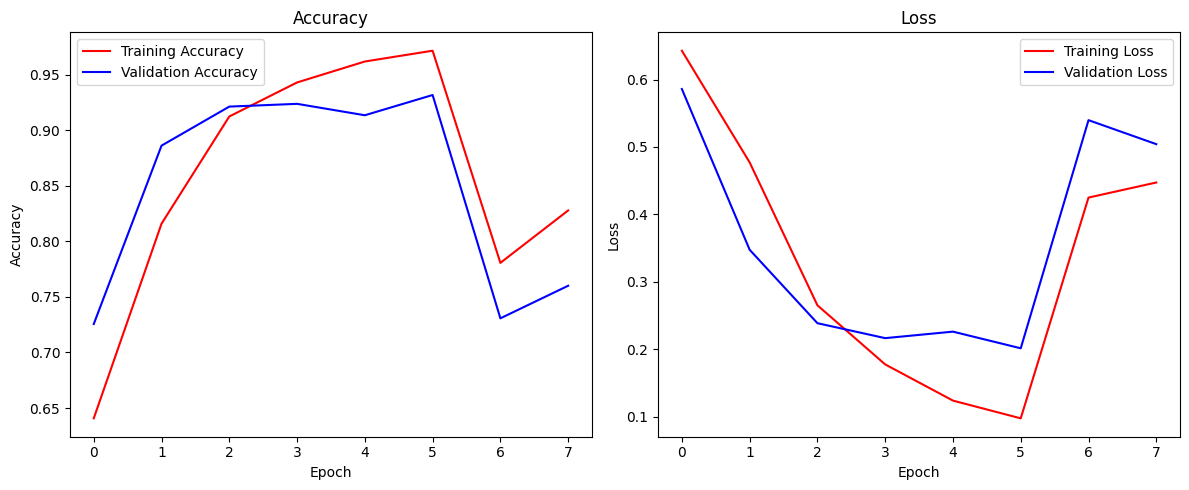

In [30]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Training Accuracy", c="red")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy", c="blue")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Training Loss", c="red")
plt.plot(history.history["val_loss"], label="Validation Loss", c="blue")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()


plt.tight_layout()
plt.show()

In [31]:
y_rnn=rnn.predict(X_test)
y_rnn = (y_rnn>0.5).astype(int)

189/189 ━━━━━━━━━━━━━━━━━━━━ 478s 3s/step


In [32]:
accuracy_score(y_test,y_rnn)

0.76006628003314

In [33]:
confusion_matrix(y_test,y_rnn)

array([[2867,  552],
       [ 896, 1720]])

In [34]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Purples):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

189/189 ━━━━━━━━━━━━━━━━━━━━ 478s 3s/step
accuracy:   0.760
Confusion matrix, without normalization


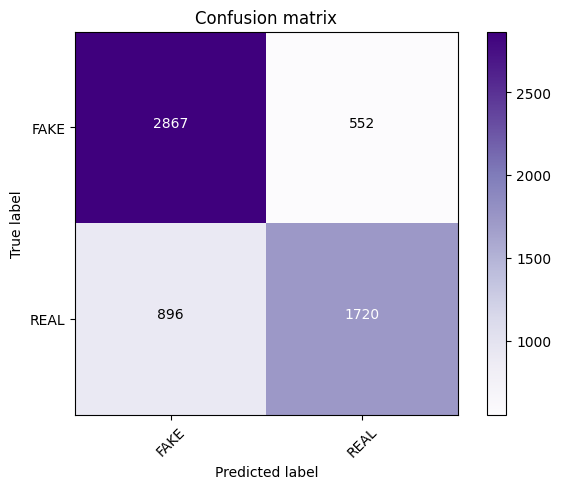

In [35]:
prediction1 = rnn.predict(X_test)
prediction1 = (prediction1 > 0.5)  # Converting probabilities to binary predictions
score = metrics.accuracy_score(y_test, prediction1)
print("accuracy:   %0.3f" % score)
cm1 = metrics.confusion_matrix(y_test, prediction1)
plot_confusion_matrix(cm1, classes=['FAKE', 'REAL'])

In [38]:

print(classification_report(y_test,y_rnn))

              precision    recall  f1-score   support

           0       0.76      0.84      0.80      3419
           1       0.76      0.66      0.70      2616

    accuracy                           0.76      6035
   macro avg       0.76      0.75      0.75      6035
weighted avg       0.76      0.76      0.76      6035



In [39]:
rnn.save('model.h5')

In [41]:
rnn.save("model.keras")

In [42]:
rnn.export("model")

Saved artifact at 'model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 142961), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  132200137743568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132200137744720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132200137745680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132200137743952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132200137745872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132200137744912: TensorSpec(shape=(), dtype=tf.resource, name=None)
